Some initial imports, do **NOT** write any new code here:

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt


from datasets import load_dataset
from huggingface_hub import hf_hub_download

In [5]:
import random


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Question 1: MRI Modality Translation (T1 → T2)

Magnetic Resonance Imaging (MRI) is a key modality for brain and brain tumour assessment. Different MRI contrasts highlight different tissue properties: for example, T1-weighted images provide good anatomical detail, while T2-weighted images are more sensitive to fluid and oedema, and often make tumour-related abnormalities more conspicuous. In clinical practice, not all contrasts are always acquired for every patient or every time point, and multi-contrast data can be incomplete or heterogeneous. Learning mappings between MRI modalities is therefore relevant for tasks such as image completion, protocol harmonisation, and data augmentation.

In this question you will work with a pre-processed dataset derived from a public brain tumour MRI collection. For each patient, paired **T1** and **T2** images have been extracted as **2D slices** from 3D volumes in several canonical views (axial, sagittal, coronal). The data have been co-registered, skull-stripped, and resampled to **single-channel 64×64** slices and split into **training** and **validation** sets. Each example includes:
- `patient_id`: an anonymised identifier for the patient  
- `split`: the dataset split (`train` or `validation`)  
- `view`: the anatomical view (`axial`, `sagittal`, or `coronal`)  
- `t1`: a 2D T1-weighted slice (shape `(1, 64, 64)`)  
- `t2`: the corresponding T2-weighted slice (same shape as `t1`)

Throughout this question, you will treat **T1 slices as inputs** and **T2 slices as targets** in an image-to-image regression setting.

This question is divided into three parts:

- **Part 1.A – Exploratory Data Analysis and Pre-processing**: you will inspect the dataset, develop simple visualisations, and design a basic intensity normalisation pipeline.  
- **Part 1.B – Modality Translation Model**: you will build and train a deep learning model that maps T1 slices to T2 slices, and evaluate its performance quantitatively and qualitatively.  
- **Part 1.C – Discussion**: you will critically reflect on your modelling choices, results, and limitations in a concise written analysis.

<br>

---

<br>

The next few blocks of code provided in the notebook will download and load the dataset from the Hugging Face Hub, and show you basic usage of the `datasets` API for accessing slices and metadata.


In [6]:
train_dataset = load_dataset("dpelacani/mri-t1-t2-2D-sliced-64", split="train")
valid_dataset = load_dataset("dpelacani/mri-t1-t2-2D-sliced-64", split="validation")

train_dataset, valid_dataset

(Dataset({
     features: ['patient_id', 'split', 'view', 't1', 't2'],
     num_rows: 116235
 }),
 Dataset({
     features: ['patient_id', 'split', 'view', 't1', 't2'],
     num_rows: 39375
 }))

In [7]:
# Applying a transform to the dataset, this can also incluse torchvision transforms
def basic_transform_fn(sample_):
    if "t1" in sample_:
        sample_["t1"] = torch.tensor(sample_["t1"])
    if "t2" in sample_:
        sample_["t2"] = torch.tensor(sample_["t2"])
    return sample_

train_dataset = train_dataset.with_transform(basic_transform_fn)
valid_dataset = valid_dataset.with_transform(basic_transform_fn)

train_dataset[0]["t1"].shape, valid_dataset[0]["t1"].shape


(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

<br><br>

## 1.A) Exploratory Data Analysis and Pre-processing

In this part you will carry out basic exploratory analysis of the paired T1/T2 slice dataset and design a simple pre-processing strategy that will be reused in Part 1.B.

Using the provided loading code and any helper functions you choose to implement, you should:

1. **Visualise representative T1–T2 pairs**  
   - For each anatomical view, plot a small grid of 8 T1/T2 pairs from the training set. Arrange the plots so that for each example the T1 input and its corresponding T2 target can be compared side-by-side (or in successive rows), and ensure that axes and titles are clearly labelled.

2. **Analyse intensity distributions**  
   - Plot histograms (or density plots) of pixel intensities for T1 and T2 slices, separately for the training and validation sets.  

3. **Design a simple intensity pre-processing transform**  
   - Based on your histograms of (2), propose and implement a basic normalisation scheme for `t1` and `t2` that is suitable for the task you will be carrying out in Part 1.B. For instance, you might try scaling the pixels to a fixed range such as \([0,1]\) or \([-1,1]\)) if you feel that is appropriate.

   - Apply this transform to the dataset and re-plot a few T1/T2 pairs and intensity histograms to verify that the transformed images are numerically well-behaved while preserving relevant anatomical structure.  


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

1. **Visualise representative T1–T2 pairs**

In [8]:
# sanity check:  available views in the training set
views = set()
for i in range(1000):
    example = train_dataset[i]
    views.add(example["view"])

views


{'axial', 'coronal', 'sagittal'}

In [22]:
# This is fast: it just reads the "view" column as a list, without applying transforms
train_views = train_dataset["view"]
len(train_views), set(train_views), train_views[:5]


(116235,
 {'axial', 'coronal', 'sagittal'},
 ['axial', 'axial', 'axial', 'axial', 'axial'])

In [17]:
import numpy as np

def get_indices_for_view_fast(all_views, view_name, n_samples=8, seed=42):
    """
    all_views: list of strings = train_dataset["view"]
    Returns up to n_samples indices i (as Python ints) such that all_views[i] == view_name.
    """
    # Collect all positions where the view matches
    all_indices = [i for i, v in enumerate(all_views) if v == view_name]

    n = min(n_samples, len(all_indices))
    rng = np.random.default_rng(seed)

    chosen = rng.choice(all_indices, size=n, replace=False)

    # numpy.int64 -> built-in int
    chosen = [int(i) for i in chosen]
    return chosen


In [20]:
import matplotlib.pyplot as plt
import torch

def plot_t1_t2_grid_for_view(dataset, all_views, view_name, n_samples=8, seed=42):
    """
    Plot a grid of T1/T2 pairs for a given view from the dataset.
    Each row: T1 (left), T2 (right).
    """
    indices = get_indices_for_view_fast(all_views, view_name, n_samples=n_samples, seed=seed)
    n = len(indices)

    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(6, 3 * n))
    if n == 1:
        axes = np.array([axes])

    for row, idx in enumerate(indices):
        sample = dataset[idx]
        t1 = sample["t1"]   # tensor (1, 64, 64)
        t2 = sample["t2"]   # tensor (1, 64, 64)

        t1_img = t1.squeeze(0).cpu().numpy()
        t2_img = t2.squeeze(0).cpu().numpy()

        # Left: T1
        ax1 = axes[row, 0]
        ax1.imshow(t1_img, cmap="gray")
        ax1.set_title(f"T1 - {view_name}, idx={idx}")
        ax1.axis("off")

        # Right: T2
        ax2 = axes[row, 1]
        ax2.imshow(t2_img, cmap="gray")
        ax2.set_title(f"T2 - {view_name}, idx={idx}")
        ax2.axis("off")

    plt.tight_layout()
    plt.show()


View: axial


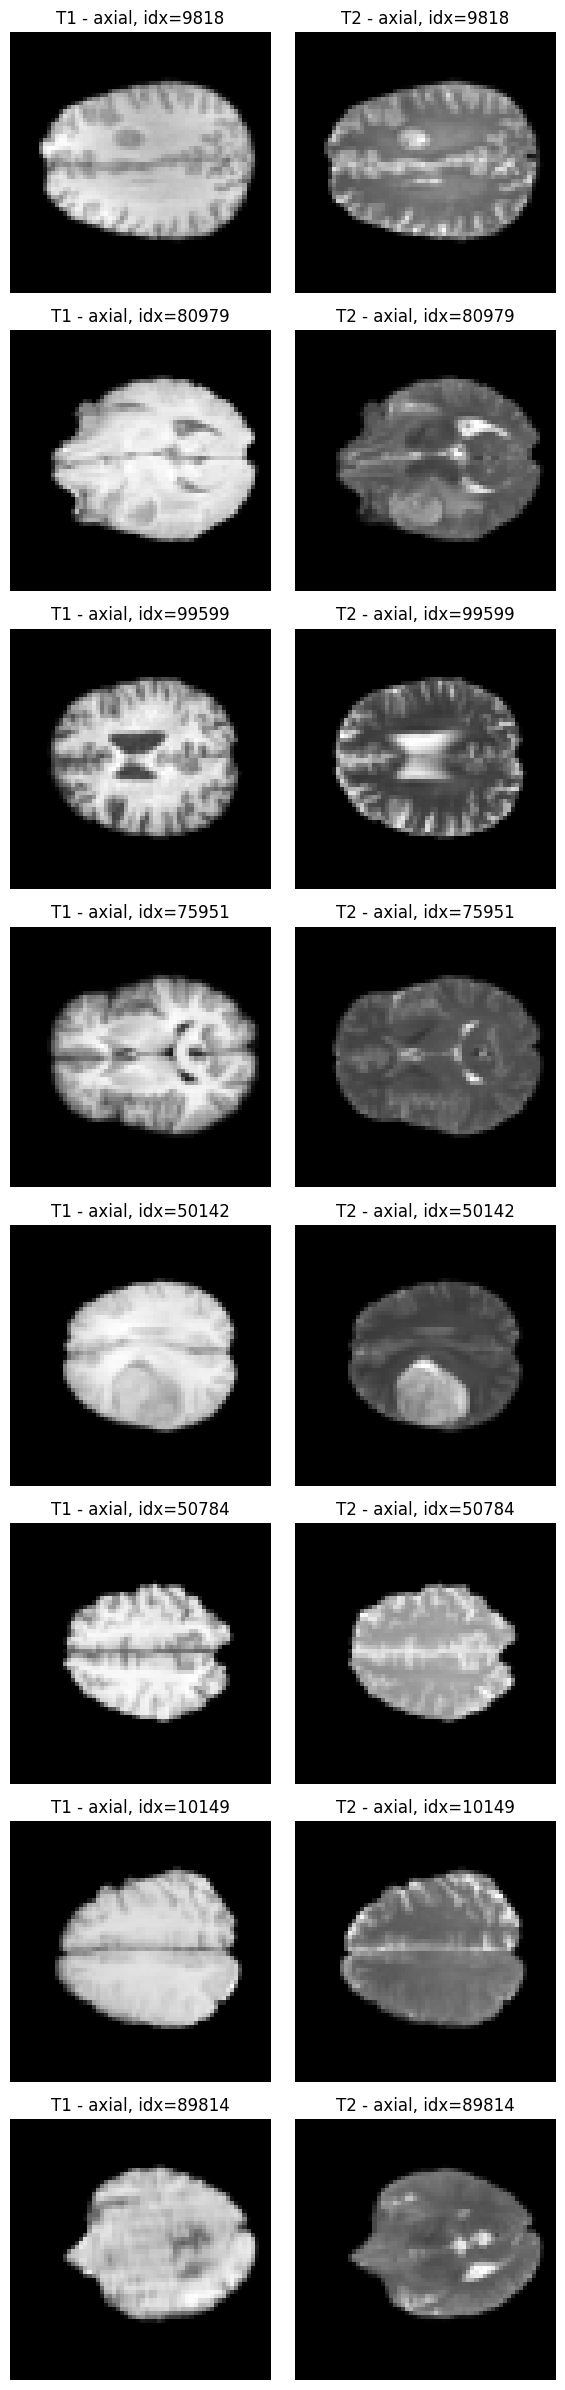

View: coronal


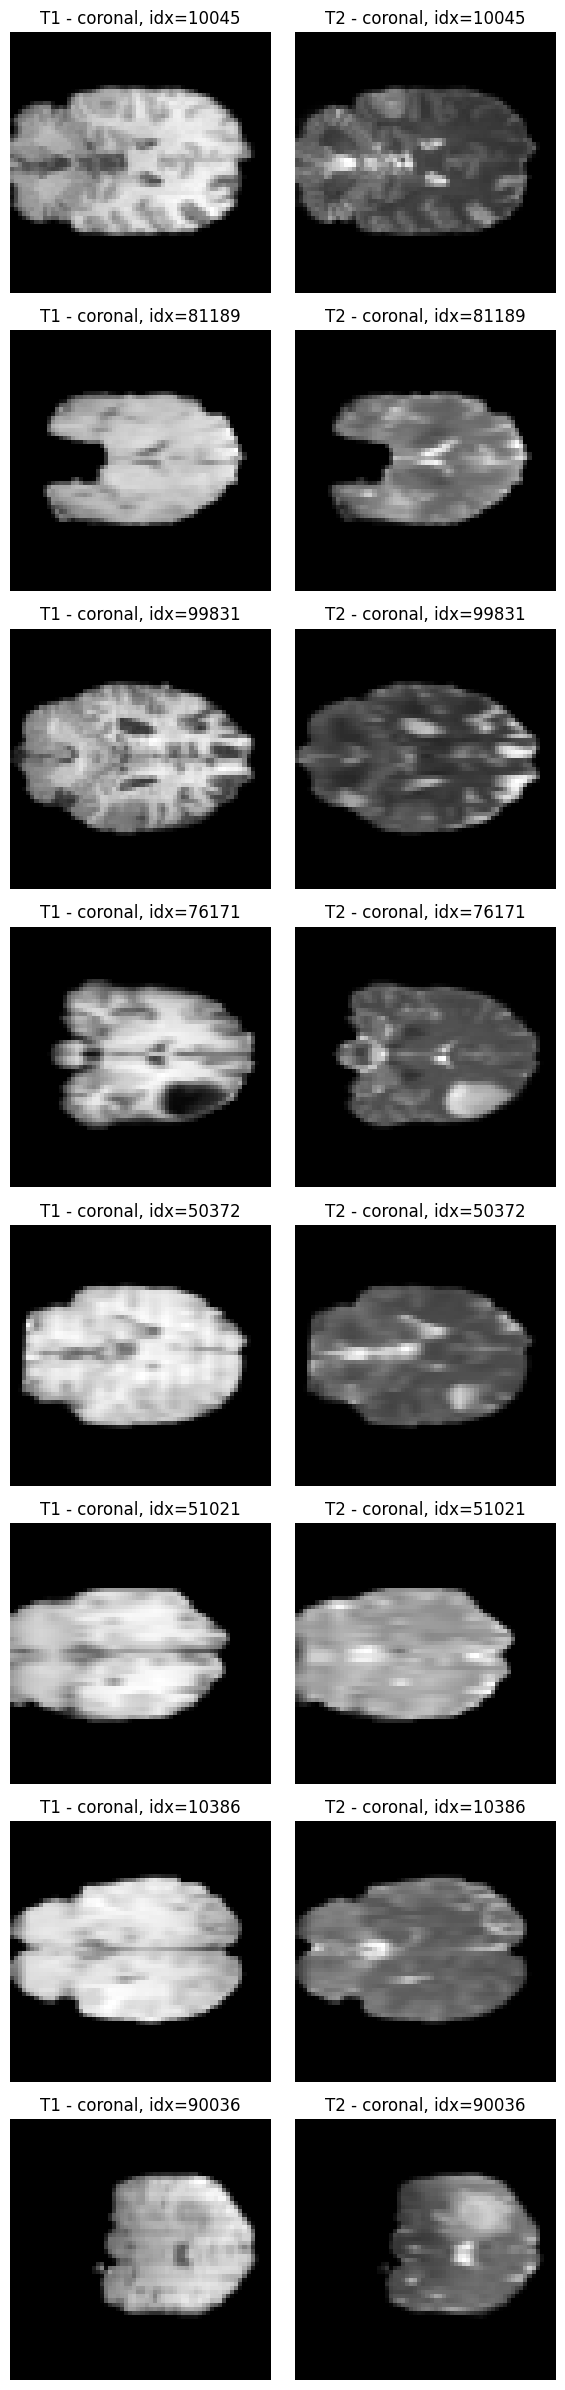

View: sagittal


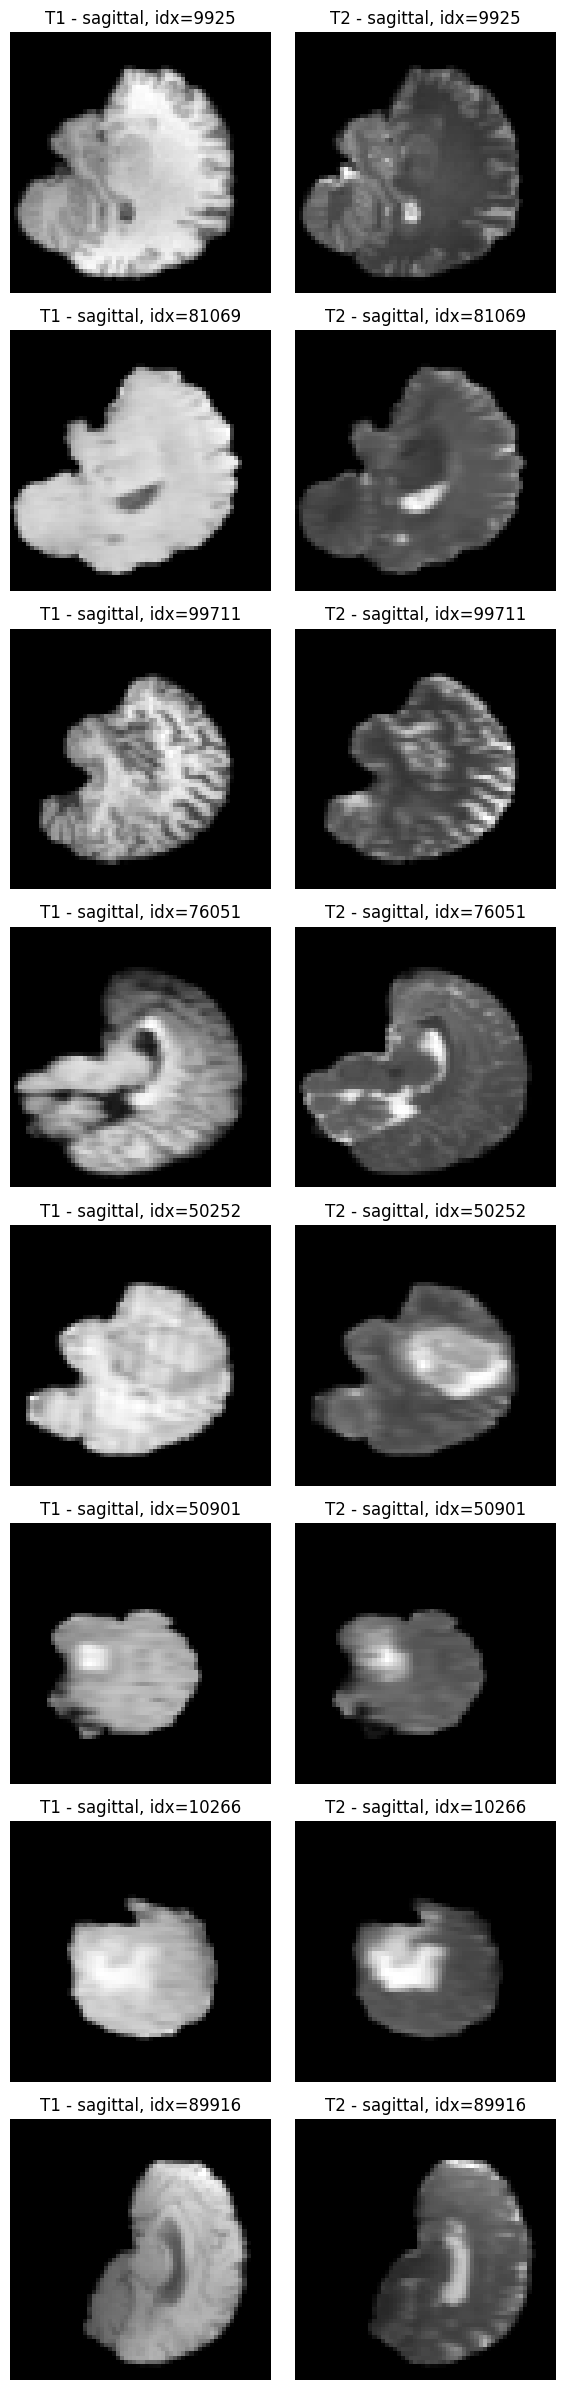

In [21]:
for view_name in ["axial", "coronal", "sagittal"]:
    print(f"View: {view_name}")
    plot_t1_t2_grid_for_view(train_dataset, train_views, view_name, n_samples=8, seed=42)


Notes:
-Anatomical structures match across modalities > confirms that the dataset is well aligned + suitable for supervised T1→T2 translation.

-Differences btw T1 and T2 images: cerebrospinal fluid is dark in T1 and very bright in T2 + white matter is brighter in T1 and comparatively darker in T2. >> translation requires learning a non linear intensity mapping rather than a simple rescaling.

-Need to use Normalization : large black background regions due to skull stripping> during training, they will dominate the loss unless we normalise carefully.

<br>

2. **Analyse intensity distributions**  

In [24]:
import numpy as np
import matplotlib.pyplot as plt

n_samples = 3000
indices = np.random.choice(len(train_dataset), size=n_samples, replace=False)

t1_train_pixels = []
t2_train_pixels = []

for idx in indices:
    s = train_dataset[int(idx)]
    t1_train_pixels.append(s["t1"].squeeze().numpy().flatten())
    t2_train_pixels.append(s["t2"].squeeze().numpy().flatten())

t1_train_pixels = np.concatenate(t1_train_pixels)
t2_train_pixels = np.concatenate(t2_train_pixels)


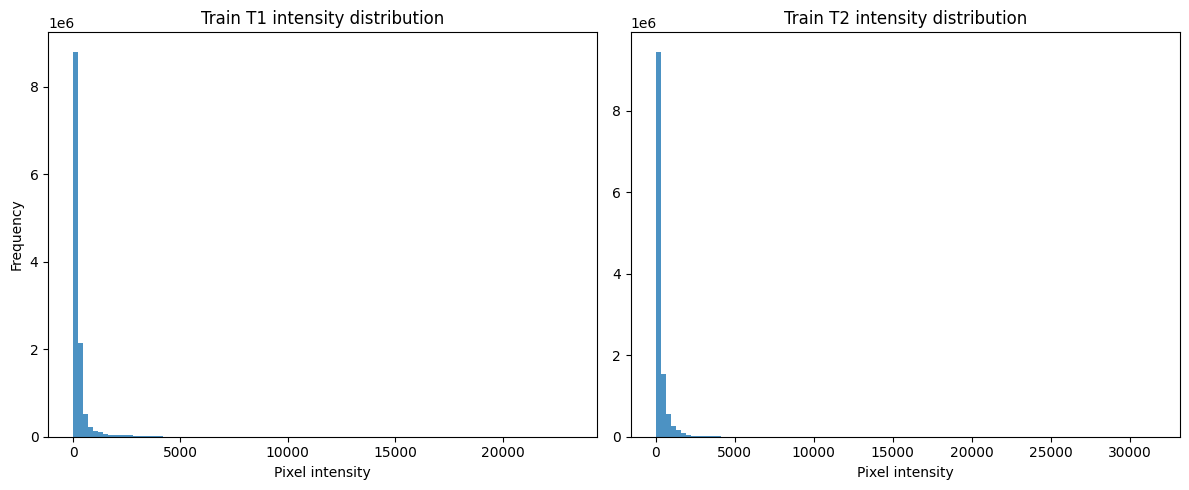

In [25]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(t1_train_pixels, bins=100, alpha=0.8)
plt.title("Train T1 intensity distribution")
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(t2_train_pixels, bins=100, alpha=0.8)
plt.title("Train T2 intensity distribution")
plt.xlabel("Pixel intensity")

plt.tight_layout()
plt.show()


In [26]:
n_val = 2000
indices_val = np.random.choice(len(valid_dataset), size=n_val, replace=False)

t1_val_pixels = []
t2_val_pixels = []

for idx in indices_val:
    s = valid_dataset[int(idx)]
    t1_val_pixels.append(s["t1"].squeeze().numpy().flatten())
    t2_val_pixels.append(s["t2"].squeeze().numpy().flatten())

t1_val_pixels = np.concatenate(t1_val_pixels)
t2_val_pixels = np.concatenate(t2_val_pixels)


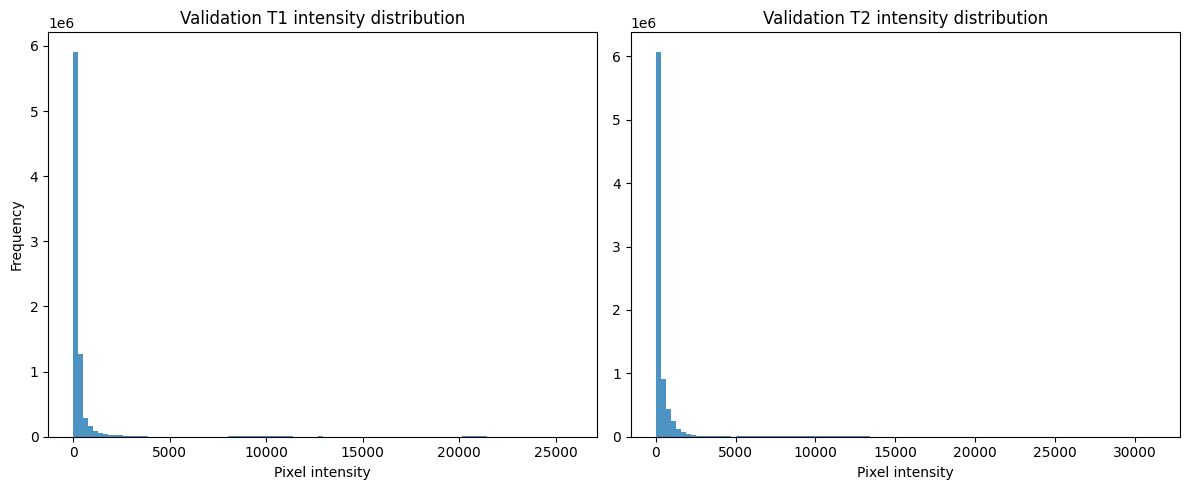

In [27]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(t1_val_pixels, bins=100, alpha=0.8)
plt.title("Validation T1 intensity distribution")
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(t2_val_pixels, bins=100, alpha=0.8)
plt.title("Validation T2 intensity distribution")
plt.xlabel("Pixel intensity")

plt.tight_layout()
plt.show()


In [29]:
import numpy as np

def compute_stats(dataset, n_samples=6000):
    idxs = np.random.choice(len(dataset), size=min(n_samples, len(dataset)), replace=False)

    t1_vals = []
    t2_vals = []

    for idx in idxs:
        s = dataset[int(idx)]
        t1_vals.append(s["t1"].squeeze().numpy().flatten())
        t2_vals.append(s["t2"].squeeze().numpy().flatten())

    t1_vals = np.concatenate(t1_vals)
    t2_vals = np.concatenate(t2_vals)

    stats = {
        "t1_min": float(np.min(t1_vals)),
        "t1_max": float(np.max(t1_vals)),
        "t1_mean": float(np.mean(t1_vals)),
        "t1_std": float(np.std(t1_vals)),

        "t2_min": float(np.min(t2_vals)),
        "t2_max": float(np.max(t2_vals)),
        "t2_mean": float(np.mean(t2_vals)),
        "t2_std": float(np.std(t2_vals)),
    }
    return stats

# Compute stats
train_stats = compute_stats(train_dataset)
val_stats = compute_stats(valid_dataset)

train_stats, val_stats


({'t1_min': 0.0,
  't1_max': 26629.068359375,
  't1_mean': 236.33718872070312,
  't1_std': 780.3374633789062,
  't2_min': 0.0,
  't2_max': 31288.333984375,
  't2_mean': 268.00543212890625,
  't2_std': 918.7495727539062},
 {'t1_min': 0.0,
  't1_max': 27820.0,
  't1_mean': 528.2540893554688,
  't1_std': 2312.716552734375,
  't2_min': 0.0,
  't2_max': 31313.5625,
  't2_mean': 460.2404479980469,
  't2_std': 1732.506103515625})

Notes:

- Only decided to plot an number of pixel because otherwise it would take hours.

-huge spike at intensity = 0 for all plots (T1 and T2, train and validation) and this is because MRI volumes were skull stripped, leaves black background around the brain so most pixels in a 64×64 slice belong to background, not tissue

- Range:
-Most brain intensities lie in 0–3000 for T1
-Most brain intensities lie in 0–4000 for T2
-are outliers up to 20k–30k in both
> So clearly MRI intensities are not standardised, each patient/scanner produces intensities on a different scale >> MUST normalise intensities before training.

<br>

3. **Design a simple intensity pre-processing transform**

Although [0,1] scaling stabilises the data, I additionally map each slice to [-1,1], following the normalisation strategy used throughout the lecture material. Zero-centred inputs improve optimisation, match the behaviour expected by many CNN architectures used in image-to-image translation, and lead to more stable and symmetric gradient flows.

<br><br>

## 1.B) Modality Translation (T1 → T2)

In this part you will build an **image-to-image model** that takes a T1-weighted slice as input and predicts the corresponding T2-weighted slice. Each training example is therefore a pair $(\text{T1}, \text{T2})$ with matching spatial dimensions.

You are free to design the model architecture, but it must satisfy the following requirements:

- It should operate on 2D slices and produce an output with the **same spatial resolution** as the input
- It should take `t1` as input and learn to approximate `t2` as output, using the pre-processed data from Part 1.A.  

In designing your solution, you must determine:

- a **suitable architecture**, keeping in mind that simpler models should remain functional and that more complex designs may yield improved performance;  
- the **loss function** and **optimisation setup** you believe appropriate for this task;  
- the **evaluation strategy**, including at least one quantitative metric and the qualitative visualisation of predicted T2 images.

Key points to consider:

- You are expected to design the full solution **yourself**: the model, the preprocessing pipeline, and the overall training procedure. You must also decide on **suitable evaluation metrics** for this problem. **Strong solutions will ensure that the model can both preserve image quality and generalise well to the validation set.**

- Only include code that is necessary to reproduce your results. Notebook organisation and clarity form part of the assessment (see the main *README*).

- You should ensure that the notebook clearly displays example outputs of your **final trained model on the validation set**, as well as at least one plot showing how your chosen **evaluation metric(s) evolve over training iterations or epochs.**

- You may include **up to two** solutions in this notebook, in recognition that partially working attempts may still receive marks under the criteria outlined in the *README*, but you are encouraged to start with a simple, reliable baseline before attempting a more complex model.


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

<br><br>

## 1.C) Discussion (max 250 words)

In this part you should provide a concise written discussion (maximum **250 words**) reflecting on your solution to Part 1.B. Your discussion should address the following points:

1. **Modelling choices and pre-processing**  
   Explain the main decisions behind your model architecture, loss function, and training strategy, and how they relate to the properties of the T1/T2 translation task.

2. **Performance and evaluation**  
   Interpret your **quantitative** results and **qualitative** reconstructions. Comment on how well your model appears to reconstruct `t2` features.

3. **Limitations and possible improvements**  
   Identify the main limitations of your current approach and outline concrete avenues for improvement. You may refer to alternative architectures, loss functions, or improved training and validation procedures.

Your answer should be technically focused, directly address these points, and remain within the stated word limit. Overly long or off-topic discussions will be penalised.


<br>

---

<br>

// Text answer

<br>

---

<br>